In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
from datetime import timedelta
import matplotlib.pyplot as plt
import seaborn as sns
from fuzzywuzzy import fuzz
from fuzzywuzzy import process
import requests

In [2]:
# https://data.world/len/dog-canine-breed-size-akc
breed_df = pd.read_csv('akc_breed_info.csv')

In [7]:
# pull outcome data from API
url = "https://austintexas-op-beta.demo.socrata.com/resource/ftta-82x4.json?$$app_token=eQF4j1pYTvsn3pqOicvC5udFj&$limit=200000"
get_data = requests.get(url, verify=False).json()
api_df = pd.DataFrame(get_data)
api_df['DateTime'] = pd.to_datetime(api_df['datetime'])
api_df['MonthYear'] = pd.to_datetime(api_df['monthyear'])

C:\Users\req93038\AppData\Local\anaconda3\lib\site-packages\urllib3\connectionpool.py:1045: InsecureRequestWarning: Unverified HTTPS request is being made to host 'austintexas-op-beta.demo.socrata.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


In [8]:
# remove non-numeric values from df
breed_df = breed_df[pd.to_numeric(breed_df['weight_high_lbs'], errors='coerce').notnull()]
# add column for median weight
breed_df['weight_median_lbs'] = (pd.to_numeric(breed_df['weight_high_lbs']) + pd.to_numeric(breed_df['weight_low_lbs']))/2

In [10]:
api_df.columns

Index(['animal_id', 'name', 'datetime', 'monthyear', 'date_of_birth',
       'outcome_type', 'animal_type', 'sex_upon_outcome', 'age_upon_outcome',
       'breed', 'color', 'outcome_subtype', 'DateTime', 'MonthYear'],
      dtype='object')

In [12]:
# Limit Data to just dogs
dog_outcome_df = api_df[api_df['animal_type'] == 'Dog'].reset_index()
# remove index column as it is not needed going forward
dog_outcome_df.drop(['index'], axis = 1, inplace = True)
# Remove duplicate values from the dataset
dog_outcome_df = dog_outcome_df[~dog_outcome_df.duplicated(keep='last')]
# break out first and second breed listed
dog_outcome_df['Breed_join'] = dog_outcome_df['breed'].str.split("/", n = 1, expand = False).str[0]

In [13]:
# function that determines ratio and token
def metrics(tup):
    return pd.Series([fuzz.ratio(*tup),
                      fuzz.token_sort_ratio(*tup)],
                     ['ratio', 'token'])
# create multi index to use fuzzy match
compare = pd.MultiIndex.from_product([breed_df['breed'],
                                      dog_outcome_df['Breed_join'].unique()]).to_series()
# Create reference to join views
breed_fuzzy = compare.apply(metrics).unstack().idxmax().unstack(0).reset_index()

In [14]:
# fix matches found by manually checking file
def update_ratio(index, ratio):
    if index in ['American Bulldog','American Bulldog Mix','English Bulldog','English Bulldog Mix','Old English Bulldog']:
        return 'Bull Dog'
    elif index in ['Lhasa Apso','Lhasa Apso Mix']:
        return 'Tibetan Terrier'
    elif index in ['Miniature Pinscher','Miniature Pinscher Mix']:
        return 'Dachshund'
    elif index in ['Pit Bull','Pit Bull Mix']:
        return 'American Staffordshire Terrier'
    elif index in ['Alaskan Malamute','Alaskan Malamute Mix']:
        return 'Siberian Husky'
    else:
        return ratio
breed_fuzzy['ratio'] = breed_fuzzy[['index','ratio']].apply(lambda breed_fuzzy: update_ratio(breed_fuzzy['index'],breed_fuzzy['ratio']),axis=1)
breed_fuzzy = breed_fuzzy[['index','ratio']].rename(columns={'index' : 'Breed_join', 'ratio' : 'Breed_primary'})

In [15]:
# join the fuzzy match df in order to bring in the weight / length df into the intake df
dog_outcome_df = pd.merge(dog_outcome_df, breed_fuzzy, how='left', left_on='Breed_join', right_on='Breed_join')

In [17]:
# adding weight / length data into dataframe
dog_outcome_df = pd.merge(dog_outcome_df, breed_df, how='left', left_on='Breed_primary', right_on='breed')#.drop('breed', axis = 1)

# Age Upon Outcome

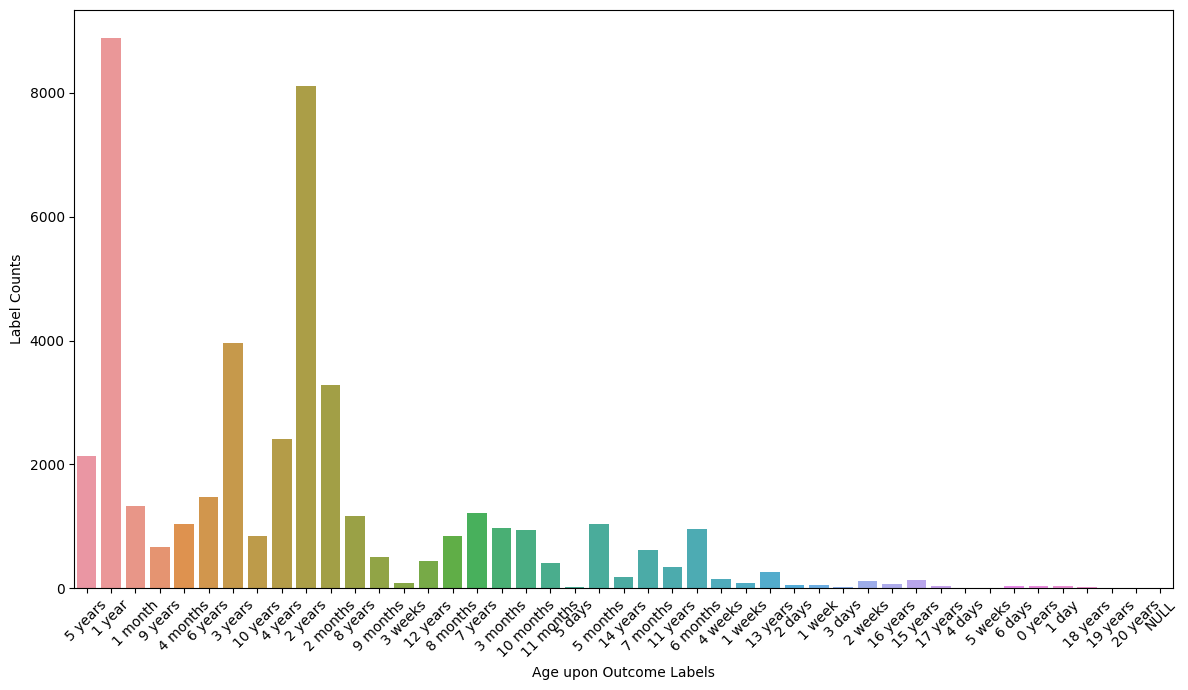

In [18]:
# Visualize data 
fig = plt.figure(figsize=(12,7))
sns.countplot(data=dog_outcome_df, x = 'age_upon_outcome')
plt.xlabel('Age upon Outcome Labels')
plt.ylabel('Label Counts')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

- Data has negative values
- Data has different denominations of time (Years, Months, Weeks, Days)

In [19]:
def age_in_months(age):
    if "year" in age:
        return float(age.split()[0]) * 12
    elif "month" in age:
        return float(age.split()[0])
    elif "week" in age:
        return float(age.split()[0]) / 4
    elif "day" in age:
        return float(age.split()[0]) / 30
    else:
        return 99999.9
    
# Remove NULL Records
dog_outcome_df = dog_outcome_df[dog_outcome_df['age_upon_outcome'].notnull()]
# Remove Negative Values from the dataset
dog_outcome_df = dog_outcome_df[~dog_outcome_df['age_upon_outcome'].str.contains("-")]
# convert Age upon Intake Labels into months
dog_outcome_df['age_outcome_months'] = dog_outcome_df['age_upon_outcome'].apply(age_in_months)

<Figure size 1200x700 with 0 Axes>

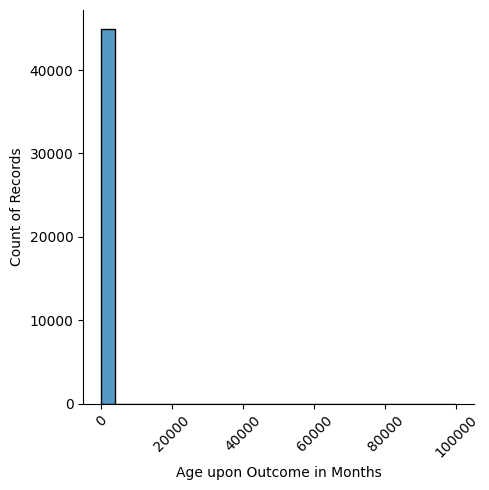

In [20]:
# Show distribution of new field
plt.figure(figsize=(12,7))
sns.displot(data=dog_outcome_df, x = 'age_outcome_months', bins = 25)
plt.xlabel('Age upon Outcome in Months')
plt.ylabel('Count of Records')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## Outcome Type

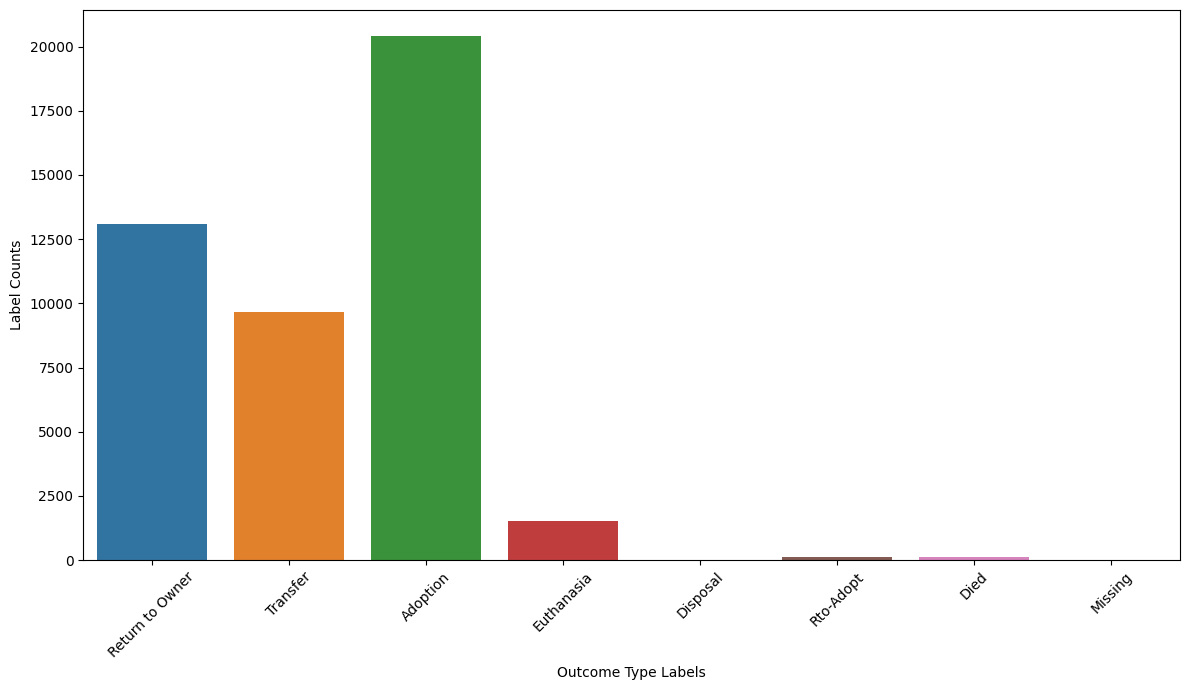

In [21]:
fig = plt.figure(figsize=(12,7))
sns.countplot(data=dog_outcome_df, x = 'outcome_type')
plt.xlabel('Outcome Type Labels')
plt.ylabel('Label Counts')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

- No Null value or odd results
- Create Dummy Values for use in future machine learning

In [22]:
dog_outcome_df['outcome_type'].fillna('Not_Specified', inplace=True)

In [23]:
# Create Dummy Variables for intake type
dog_outcome_df = pd.get_dummies(dog_outcome_df, columns=['outcome_type']) 
dog_outcome_df.head(5)

,animal_id,name,datetime,monthyear,date_of_birth,animal_type,sex_upon_outcome,age_upon_outcome,breed_x,color,...,age_outcome_months,outcome_type_Adoption,outcome_type_Died,outcome_type_Disposal,outcome_type_Euthanasia,outcome_type_Missing,outcome_type_Not_Specified,outcome_type_Return to Owner,outcome_type_Rto-Adopt,outcome_type_Transfer
0,A658751,Benji,2016-11-13T13:38:00.000,2016-11-13T13:38:00.000,2011-07-14T00:00:00.000,Dog,Neutered Male,5 years,Border Terrier Mix,Tan,...,60.0,0,0,0,0,0,0,1,0,0
1,A746650,Rose,2017-04-07T11:58:00.000,2017-04-07T11:58:00.000,2016-04-06T00:00:00.000,Dog,Intact Female,1 year,Labrador Retriever/Jack Russell Terrier,Yellow,...,12.0,0,0,0,0,0,0,1,0,0
2,A750122,Happy Camper,2017-05-24T18:36:00.000,2017-05-24T18:36:00.000,2017-04-08T00:00:00.000,Dog,Intact Male,1 month,Labrador Retriever Mix,Black,...,1.0,0,0,0,0,0,0,0,0,1
3,A666430,Lucy,2013-11-07T11:47:00.000,2013-11-07T11:47:00.000,2012-11-06T00:00:00.000,Dog,Spayed Female,1 year,Beagle Mix,White/Brown,...,12.0,0,0,0,0,0,0,0,0,1
4,A675708,*Johnny,2014-06-03T14:20:00.000,2014-06-03T14:20:00.000,2013-03-31T00:00:00.000,Dog,Neutered Male,1 year,Pit Bull,Blue/White,...,12.0,1,0,0,0,0,0,0,0,0


## Sex upon Outcome

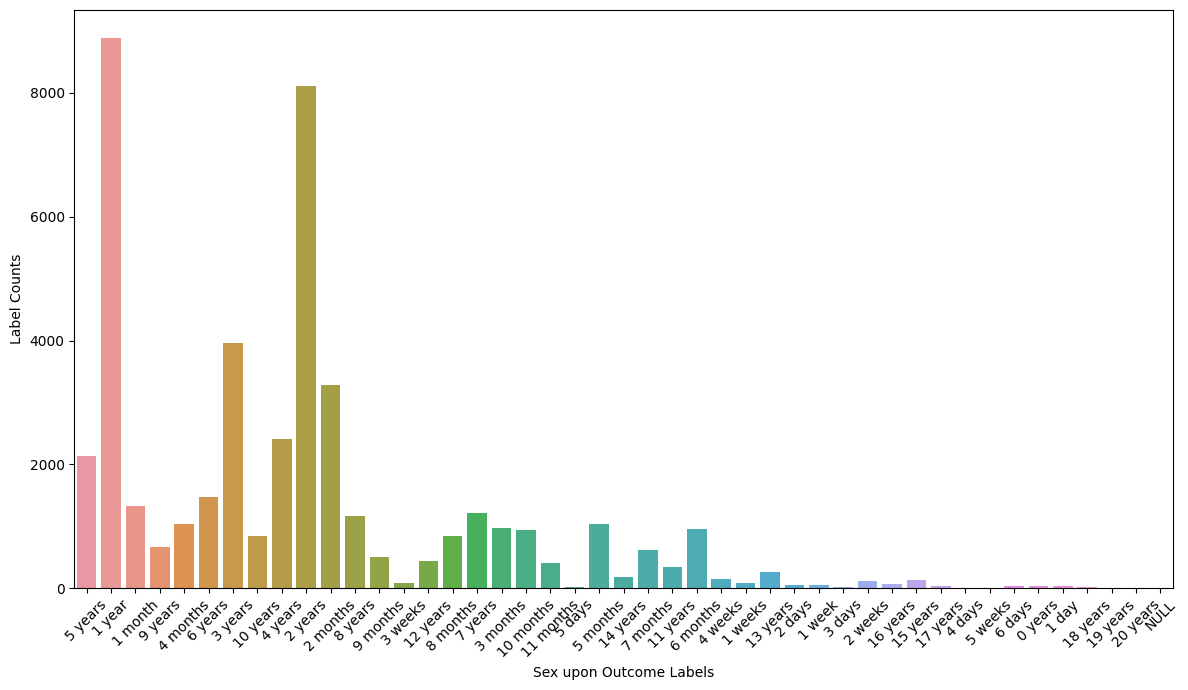

In [24]:
# Visualize data
fig = plt.figure(figsize=(12,7))
sns.countplot(data=dog_outcome_df, x = 'age_upon_outcome')
plt.xlabel('Sex upon Outcome Labels')
plt.ylabel('Label Counts')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [25]:
unknown_sex_perc = (len(dog_outcome_df[dog_outcome_df['age_upon_outcome'] == 'Unknown']) / len(dog_outcome_df)) * 100
from IPython.display import Markdown, display
display(Markdown(f""" 
- Unknown records account for {round(unknown_sex_perc, 2)} percent of the records
- Will create a flag indicating if they are fixed 
- Will create a flag indicating if they are male
"""))

 
- Unknown records account for 0.0 percent of the records
- Will create a flag indicating if they are fixed 
- Will create a flag indicating if they are male


In [26]:
def fix_flg(sex):
    if sex in ['Neutered Male','Spayed Female']:
        return 1
    else:
        return 0
# Remove NULL Records from the Sex upon Intake column
dog_outcome_df = dog_outcome_df[dog_outcome_df['age_upon_outcome'].notnull()]
# Creates a flag that determines whether the dog was spayed/neutered
dog_outcome_df['fix_flg'] = dog_outcome_df['age_upon_outcome'].apply(fix_flg)
dog_outcome_df.head(5)

,animal_id,name,datetime,monthyear,date_of_birth,animal_type,sex_upon_outcome,age_upon_outcome,breed_x,color,...,outcome_type_Adoption,outcome_type_Died,outcome_type_Disposal,outcome_type_Euthanasia,outcome_type_Missing,outcome_type_Not_Specified,outcome_type_Return to Owner,outcome_type_Rto-Adopt,outcome_type_Transfer,fix_flg
0,A658751,Benji,2016-11-13T13:38:00.000,2016-11-13T13:38:00.000,2011-07-14T00:00:00.000,Dog,Neutered Male,5 years,Border Terrier Mix,Tan,...,0,0,0,0,0,0,1,0,0,0
1,A746650,Rose,2017-04-07T11:58:00.000,2017-04-07T11:58:00.000,2016-04-06T00:00:00.000,Dog,Intact Female,1 year,Labrador Retriever/Jack Russell Terrier,Yellow,...,0,0,0,0,0,0,1,0,0,0
2,A750122,Happy Camper,2017-05-24T18:36:00.000,2017-05-24T18:36:00.000,2017-04-08T00:00:00.000,Dog,Intact Male,1 month,Labrador Retriever Mix,Black,...,0,0,0,0,0,0,0,0,1,0
3,A666430,Lucy,2013-11-07T11:47:00.000,2013-11-07T11:47:00.000,2012-11-06T00:00:00.000,Dog,Spayed Female,1 year,Beagle Mix,White/Brown,...,0,0,0,0,0,0,0,0,1,0
4,A675708,*Johnny,2014-06-03T14:20:00.000,2014-06-03T14:20:00.000,2013-03-31T00:00:00.000,Dog,Neutered Male,1 year,Pit Bull,Blue/White,...,1,0,0,0,0,0,0,0,0,0


In [27]:
# break out a flag if the dog is identified as male
def male_flg(sex):
    if sex in ['Neutered Male','Intact Male']:
        return 1
    else:
        return 0
dog_outcome_df['male_flg'] = dog_outcome_df['age_upon_outcome'].apply(male_flg)
dog_outcome_df.head(5)

,animal_id,name,datetime,monthyear,date_of_birth,animal_type,sex_upon_outcome,age_upon_outcome,breed_x,color,...,outcome_type_Died,outcome_type_Disposal,outcome_type_Euthanasia,outcome_type_Missing,outcome_type_Not_Specified,outcome_type_Return to Owner,outcome_type_Rto-Adopt,outcome_type_Transfer,fix_flg,male_flg
0,A658751,Benji,2016-11-13T13:38:00.000,2016-11-13T13:38:00.000,2011-07-14T00:00:00.000,Dog,Neutered Male,5 years,Border Terrier Mix,Tan,...,0,0,0,0,0,1,0,0,0,0
1,A746650,Rose,2017-04-07T11:58:00.000,2017-04-07T11:58:00.000,2016-04-06T00:00:00.000,Dog,Intact Female,1 year,Labrador Retriever/Jack Russell Terrier,Yellow,...,0,0,0,0,0,1,0,0,0,0
2,A750122,Happy Camper,2017-05-24T18:36:00.000,2017-05-24T18:36:00.000,2017-04-08T00:00:00.000,Dog,Intact Male,1 month,Labrador Retriever Mix,Black,...,0,0,0,0,0,0,0,1,0,0
3,A666430,Lucy,2013-11-07T11:47:00.000,2013-11-07T11:47:00.000,2012-11-06T00:00:00.000,Dog,Spayed Female,1 year,Beagle Mix,White/Brown,...,0,0,0,0,0,0,0,1,0,0
4,A675708,*Johnny,2014-06-03T14:20:00.000,2014-06-03T14:20:00.000,2013-03-31T00:00:00.000,Dog,Neutered Male,1 year,Pit Bull,Blue/White,...,0,0,0,0,0,0,0,0,0,0


## Breed

In [29]:
dog_outcome_df.columns

Index(['animal_id', 'name', 'datetime', 'monthyear', 'date_of_birth',
       'animal_type', 'sex_upon_outcome', 'age_upon_outcome', 'breed_x',
       'color', 'outcome_subtype', 'DateTime', 'MonthYear', 'Breed_join',
       'Breed_primary', 'breed_y', 'height_low_inches', 'height_high_inches',
       'weight_low_lbs', 'weight_high_lbs', 'weight_median_lbs',
       'age_outcome_months', 'outcome_type_Adoption', 'outcome_type_Died',
       'outcome_type_Disposal', 'outcome_type_Euthanasia',
       'outcome_type_Missing', 'outcome_type_Not_Specified',
       'outcome_type_Return to Owner', 'outcome_type_Rto-Adopt',
       'outcome_type_Transfer', 'fix_flg', 'male_flg'],
      dtype='object')

In [30]:
# Adds a flag that determines whether or not the dog is of mixed breed
def mix_flg(breed):
    if "mix" in breed.lower():    
        return 1
    elif "/" in breed:
        return 1
    else:
        return 0
dog_outcome_df['mix_flg'] = dog_outcome_df['breed_x'].apply(mix_flg)
dog_outcome_df.head(5)

,animal_id,name,datetime,monthyear,date_of_birth,animal_type,sex_upon_outcome,age_upon_outcome,breed_x,color,...,outcome_type_Disposal,outcome_type_Euthanasia,outcome_type_Missing,outcome_type_Not_Specified,outcome_type_Return to Owner,outcome_type_Rto-Adopt,outcome_type_Transfer,fix_flg,male_flg,mix_flg
0,A658751,Benji,2016-11-13T13:38:00.000,2016-11-13T13:38:00.000,2011-07-14T00:00:00.000,Dog,Neutered Male,5 years,Border Terrier Mix,Tan,...,0,0,0,0,1,0,0,0,0,1
1,A746650,Rose,2017-04-07T11:58:00.000,2017-04-07T11:58:00.000,2016-04-06T00:00:00.000,Dog,Intact Female,1 year,Labrador Retriever/Jack Russell Terrier,Yellow,...,0,0,0,0,1,0,0,0,0,1
2,A750122,Happy Camper,2017-05-24T18:36:00.000,2017-05-24T18:36:00.000,2017-04-08T00:00:00.000,Dog,Intact Male,1 month,Labrador Retriever Mix,Black,...,0,0,0,0,0,0,1,0,0,1
3,A666430,Lucy,2013-11-07T11:47:00.000,2013-11-07T11:47:00.000,2012-11-06T00:00:00.000,Dog,Spayed Female,1 year,Beagle Mix,White/Brown,...,0,0,0,0,0,0,1,0,0,1
4,A675708,*Johnny,2014-06-03T14:20:00.000,2014-06-03T14:20:00.000,2013-03-31T00:00:00.000,Dog,Neutered Male,1 year,Pit Bull,Blue/White,...,0,0,0,0,0,0,0,0,0,0


## Color

In [ ]:
# break out black dogs into its own flag where black was the only color recorded
dog_outcome_df['Color_Black'] = np.where(dog_outcome_df['color'] == 'Black', 1, 0)
dog_outcome_df.head(5)

In [ ]:
# Adds a flag if the dog has any black color recorded.
dog_outcome_df['Color_Any_Black'] = np.where(dog_outcome_df['Color'].str.contains('Black'), 1, 0)
dog_outcome_df.head(5)

In [ ]:
# double check nulls
dog_outcome_df.isnull().sum()

&emsp; There are several ethical implications to consider when pulling data from an API for use in machine learning in Python:
1. Privacy: When using data from an API, it is important to ensure that the data does not contain any sensitive or personally identifiable information (PII) about individuals. If the data does contain PII, there may be legal or ethical obligations to obtain informed consent from the individuals before using their data.
2. Bias: Machine learning models are only as good as the data they are trained on. If the data used to train a model is biased, the model may also be biased and produce unfair or discriminatory results. It is important to carefully consider the potential biases in the data and take steps to mitigate them, such as using representative samples or removing variables that are known to be correlated with bias.
3. Ownership: It is important to consider who owns the data being used in the machine learning model. If the data is owned by a third party, there may be legal or ethical obligations to obtain permission or pay for access to the data.

In [ ]:
dog_outcome_df.to_csv('dog_outcome_clean_df.csv', index=False)